In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. MLP sin variables exogenas
---

In [25]:
df = pd.read_csv('./data/daily_hospitalized_patients.csv', parse_dates=['date'])
df = df.sort_values('date')
# Extreamos los pacientes y lo convertimos en una matriz columna
y = df['num_patients'].values.reshape(-1, 1)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          728 non-null    datetime64[ns]
 1   num_patients  728 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.5 KB


In [27]:
# Crear las ventanas de tiempo (con lags)
# Transformamos la serie temporal en un formato supervisado
def create_lags(series, n_lags=7):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i-n_lags:i, 0])
        y.append(series[i, 0])
    return np.array(X), np.array(y)

# Escalar la serie 
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

# Crear ventanas 
n_lags = 7
X, y_lagged = create_lags(y_scaled, n_lags)


In [28]:

# División temporal 
X_train, X_test, y_train, y_test = train_test_split(
    X, y_lagged, test_size=0.2, shuffle=False
)

In [29]:
# --- Entrenar MLP ---
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42, 
    early_stopping=True
)
mlp.fit(X_train, y_train);

In [30]:
# --- Predicción sobre el conjunto de test ---
y_pred = mlp.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))

# --- Métricas ---
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"Evaluación (1 día): MAE={mae:.2f}, R²={r2:.3f}")

Evaluación (1 día): MAE=11.07, R²=0.697


## Prediccion para los 7 dias futuros

In [31]:
# Tomamos los ultimos 7 valores conocidos
last_window = y_scaled[-n_lags:].flatten()
future_preds = []

for _ in range(7):
    next_pred = mlp.predict(last_window.reshape(1, -1))[0]
    future_preds.append(next_pred)
    last_window = np.append(last_window[1:], next_pred)

future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()

# Índices de cada segmento
train_idx = np.arange(len(y_train))
test_idx = np.arange(len(y_train), len(y_train) + len(y_test))
future_idx = np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 7)

# Serie completa inversa
y_inv = scaler.inverse_transform(y_scaled)



In [32]:
print("\nPredicción a 7 días:")
for i, val in enumerate(future_preds_inv, start=1):
    print(f"  Día {i:}: {round(val)} pacientes")



Predicción a 7 días:
  Día 1: 169 pacientes
  Día 2: 171 pacientes
  Día 3: 169 pacientes
  Día 4: 168 pacientes
  Día 5: 165 pacientes
  Día 6: 164 pacientes
  Día 7: 162 pacientes


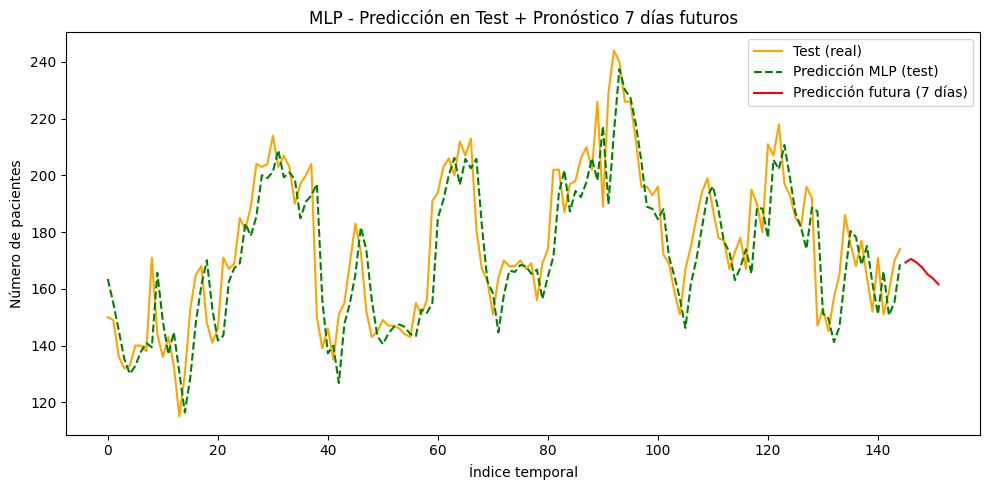

In [33]:
# Índices
test_idx = np.arange(len(y_test_inv))
future_idx = np.arange(len(y_test_inv), len(y_test_inv) + len(future_preds_inv))

# Gráfico 
plt.figure(figsize=(10,5))
plt.plot(test_idx, y_test_inv, label='Test (real)', color='orange')
plt.plot(test_idx, y_pred_inv, label='Predicción MLP (test)', color='green', linestyle='--')
plt.plot(future_idx, future_preds_inv, label='Predicción futura (7 días)', color='red')

plt.title('MLP - Predicción en Test + Pronóstico 7 días futuros')
plt.xlabel('Índice temporal')
plt.ylabel('Número de pacientes')
plt.legend()
plt.tight_layout()
plt.show()

# 2. MLP con variables exogenas
---

In [34]:
df_weather = pd.read_csv('./data/HDHI_pollution_data.csv')
df_weather['DATE'] = pd.to_datetime(
  df_weather['DATE'], 
  dayfirst=False, 
  errors='coerce'
)

In [35]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df_weather['DATE'] = pd.to_datetime(df_weather['DATE'], errors='coerce')

# Columnas de interés (ajusta nombres si en tu CSV son distintos)
wanted = ['DATE', 'AQI', 'MAX TEMP', 'MIN TEMP', 'HUMIDITY']
present = [c for c in wanted if c in df_weather.columns]

# Seleccionar y, si hay duplicados por fecha, agregarlos por media
dfw_sel = df_weather[present].copy()
if dfw_sel['DATE'].duplicated().any():
    dfw_sel = dfw_sel.groupby('DATE', as_index=False).mean()

# Merge por fecha (left join para conservar daily_counts)
df_exogen = pd.merge(df, dfw_sel, left_on='date', right_on='DATE', how='left')

# Limpiar/renombrar columnas para análisis posterior
df_exogen = df_exogen.drop(columns=['DATE'], errors='ignore').rename(
    columns={
        'AQI': 'aqi',
        'MAX TEMP': 'max_temp',
        'MIN TEMP': 'min_temp',
        'HUMIDITY': 'humidity'
    }
)

# Forzar numérico en las columnas añadidas
for col in ['aqi', 'max_temp', 'min_temp', 'humidity']:
    if col in df_exogen.columns:
        df_exogen[col] = pd.to_numeric(df_exogen[col], errors='coerce')


mean_humidity = df_exogen['humidity'].mean()
df_exogen['humidity'] = df_exogen['humidity'].fillna(mean_humidity).round(2)

df_exogen.head()


,date,num_patients,aqi,max_temp,min_temp,humidity
0,2017-04-01,30,52,40,24,16.0
1,2017-04-02,45,59,40,21,14.0
2,2017-04-03,65,70,39,22,14.0
3,2017-04-04,78,70,39,23,23.0
4,2017-04-05,71,88,36,20,51.0


In [36]:
df_exogen = df_exogen.sort_values('date')
# Extraemos los pacientes y lo convertimos en una matriz columna
y = df_exogen['num_patients'].values.reshape(-1, 1)

In [37]:
# Escaladores
scaler_y = MinMaxScaler()
scaler_x = MinMaxScaler()

# Escalar la variable objetivo 
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Preprocesamos las variables exogenas
df_exogen_proc = df_exogen.copy()

# Si hay columnas de fecha, convertirlas a componentes numéricos
for col in df_exogen_proc.select_dtypes(include=['datetime64[ns]']).columns:
    df_exogen_proc[f'{col}_day'] = df_exogen_proc[col].dt.day
    df_exogen_proc[f'{col}_month'] = df_exogen_proc[col].dt.month
    df_exogen_proc[f'{col}_weekday'] = df_exogen_proc[col].dt.weekday
    df_exogen_proc = df_exogen_proc.drop(columns=[col])

# Asegurar todo numérico
df_exogen_proc = df_exogen_proc.apply(pd.to_numeric, errors='coerce').fillna(0)



In [38]:
df_exogen_proc

,num_patients,aqi,max_temp,min_temp,humidity,date_day,date_month,date_weekday
0,30,52,40,24,16.0,1,4,5
1,45,59,40,21,14.0,2,4,6
2,65,70,39,22,14.0,3,4,0
3,78,70,39,23,23.0,4,4,1
4,71,88,36,20,51.0,5,4,2
...,...,...,...,...,...,...,...,...
723,171,69,27,15,51.0,25,3,0
724,151,98,29,15,51.0,26,3,1
725,159,93,30,16,35.0,27,3,2
726,170,103,31,17,32.0,28,3,3


In [39]:
# Escalar exógenas
X_exogen_scaled = scaler_x.fit_transform(df_exogen_proc.values)

# Creamos las ventanas
n_lags = 7
X_lags, y_target = create_lags(y_scaled, n_lags)
X_exogen_lagged = X_exogen_scaled[n_lags:]

# Alinear tamaños
min_len = min(len(X_lags), len(X_exogen_lagged))
X_lags = X_lags[-min_len:]
X_exogen_lagged = X_exogen_lagged[-min_len:]
y_target = y_target[-min_len:]

# Combinar lags + exógenas
X_total = np.hstack([X_lags, X_exogen_lagged]) 

# División temporal
X_train, X_test, y_train, y_test = train_test_split(
    X_total, y_target, test_size=0.2, shuffle=False
)

In [40]:
# Entrenamos el modelo
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32, 16),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42,
    early_stopping=True
)
mlp.fit(X_train, y_train.ravel());

In [41]:
# Realizamos las predicciones sobre el conjunto de test
y_pred = mlp.predict(X_test)

# Invertir escalado
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

# Métricas
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"Evaluación en test:")
print(f"MAE = {mae:.2f}")
print(f"R²  = {r2:.3f}")

Evaluación en test:
MAE = 1.63
R²  = 0.993


In [44]:
# Pronosticamos a 7 dias futuros
last_window = y_scaled[-n_lags:].flatten()

future_exogen = df_exogen_proc.tail(7)
future_exogen_scaled = scaler_x.transform(future_exogen.values)

future_preds_scaled = []

for i in range(7):
    # Crear input: lags + exógenas del día i
    X_future = np.concatenate([last_window[-n_lags:], future_exogen_scaled[i]])
    y_future_scaled = mlp.predict(X_future.reshape(1, -1))[0]
    future_preds_scaled.append(y_future_scaled)
    # Actualizar la ventana con la nueva predicción
    last_window = np.append(last_window, y_future_scaled)

# Invertir escalado
future_preds_inv = scaler_y.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1))

print("\n--- Pronóstico a 7 días ---")
for i, val in enumerate(future_preds_inv, start=1):
    print(f"Día {i}: {round(val[0])} pacientes")



--- Pronóstico a 7 días ---
Día 1: 165 pacientes
Día 2: 153 pacientes
Día 3: 171 pacientes
Día 4: 155 pacientes
Día 5: 159 pacientes
Día 6: 170 pacientes
Día 7: 176 pacientes


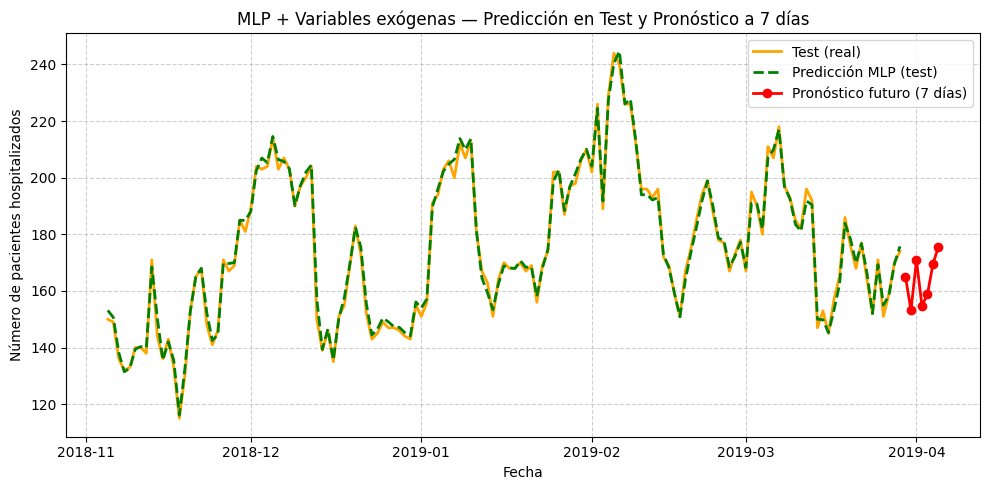

In [48]:
# --- Índices temporales ---
test_idx = np.arange(len(y_test_inv))
future_idx = np.arange(len(y_test_inv), len(y_test_inv) + len(future_preds_inv))

# Fechas alineadas para test (tras aplicar n_lags y el split)
dates_aligned = df_exogen['date'].iloc[n_lags:]                          # descarta los primeros n_lags
dates_aligned = dates_aligned.iloc[-(len(y_train) + len(y_test)):]       # últimas muestras usadas
test_dates = dates_aligned.iloc[len(y_train):]                           # fechas del bloque de test

# Fechas futuras (siguientes 7 días)
last_date = dates_aligned.iloc[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=len(future_preds_inv), freq='D')

# --- Gráfico combinado con fechas ---
plt.figure(figsize=(10,5))
plt.plot(test_dates, y_test_inv.ravel(), label='Test (real)', color='orange', linewidth=2)
plt.plot(test_dates, y_pred_inv.ravel(), label='Predicción MLP (test)', color='green', linestyle='--', linewidth=2)
plt.plot(future_dates, future_preds_inv.ravel(), label='Pronóstico futuro (7 días)', color='red', marker='o', linewidth=2)

plt.title('MLP + Variables exógenas — Predicción en Test y Pronóstico a 7 días')
plt.xlabel('Fecha')
plt.ylabel('Número de pacientes hospitalizados')
ax = plt.gca()
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


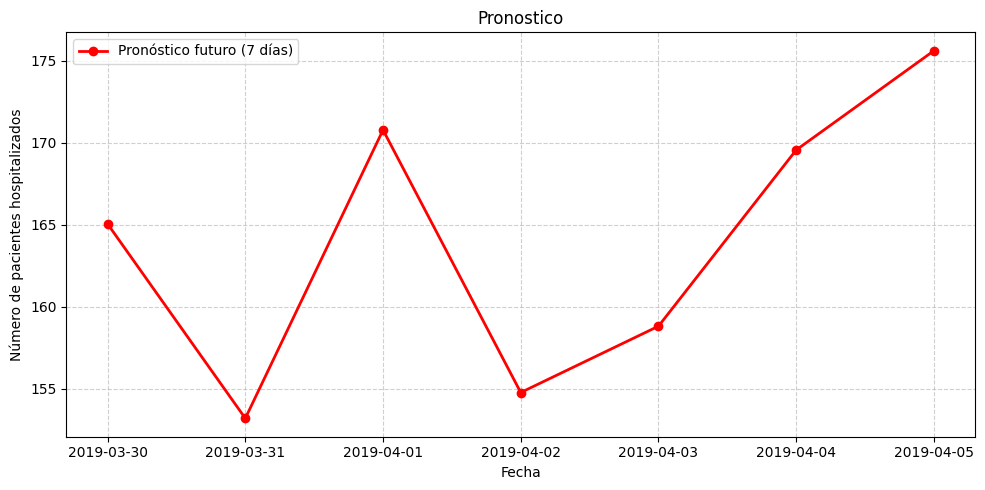

In [51]:
# --- Gráfico combinado con fechas ---
plt.figure(figsize=(10,5))

plt.plot(future_dates, future_preds_inv.ravel(), label='Pronóstico futuro (7 días)', color='red', marker='o', linewidth=2)

plt.title('Pronostico')
plt.xlabel('Fecha')
plt.ylabel('Número de pacientes hospitalizados')
ax = plt.gca()
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()